basic imports

In [3]:
import numpy as np
import pandas as pd


 initialization of dataframe

In [4]:
DATA_PATH = "../data/raw/electricity.csv"
df = pd.read_csv(DATA_PATH)


a basic test of the dataframe

In [11]:
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,b'UP'
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,b'UP'
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,b'UP'
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,b'UP'
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,b'DOWN'


Some data plotting with matplotlib

In [ ]:
import matplotlib.pyplot as plt


days = df['day'].unique()

plt.figure(figsize=(10,6))

for day in days:
    subset = df[df['day'] == day]
    plt.hist(subset['nswdemand'], bins=50, alpha=0.4, label=day)

plt.xlabel("NSW Electricity Demand")
plt.ylabel("Frequency")
plt.title("Distribution of NSW Electricity Demand by Day")
plt.legend()
plt.show()

While NSW electricity demand distributions overlap across days, mid-week days exhibit a systematic rightward shift and heavier upper tails, indicating both higher typical demand and increased frequency of extreme load conditions.

In [ ]:
plt.figure(figsize=(10,6))
df.boxplot(column='nswdemand', by='day', grid=False)
plt.xlabel("Day of Week")
plt.ylabel("NSW Electricity Demand")
plt.title("Electricity Demand by Day of Week")
plt.suptitle("") 
plt.show()

NSW electricity demand exhibits a strong weekly seasonality, peaking consistently during mid-week business days and dropping sharply on weekends. This pattern reflects the dominance of commercial and industrial load in the NSW market. Demand is highly synchronized with Victoria, indicating regional coupling, while inter-state transfers act as a stabilizing response to demand shocks. Importantly, higher-than-average NSW demand is strongly associated with upward price movements, even after removing long-term price trends

preparing dataframe for model

In [18]:
X_model_1 = df.drop(columns=['nswdemand'])
y_model_1 = df['nswdemand']


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np


In [5]:
# Define X/y
X = df.drop(columns=['nswdemand'])
y = df['nswdemand']

# If your 'day' and 'class' are bytes-like, decode safely:
# (If they are already strings, this won't hurt)
X = X.copy()
X['day'] = X['day'].astype(str).str.replace("^b'|'+$", "", regex=True)
X['class'] = X['class'].astype(str).str.replace("^b'|'+$", "", regex=True)

# Columns
categorical = ['day', 'class']
numeric = [c for c in X.columns if c not in categorical]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ],
    remainder='drop'
)


In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])


In [7]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = Pipeline(steps=[
    ('prep', preprocess),
    ('model', HistGradientBoostingRegressor(
        random_state=42,
        max_depth=6,
        learning_rate=0.05,
        max_iter=500
    ))
])


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

hgb.fit(X_train, y_train)
pred_hgb = hgb.predict(X_test)
rmse_hgb = np.sqrt(mean_squared_error(y_test, pred_hgb))

# rmse_rf, rmse_hgb


In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Random Forest RMSE
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# HistGradientBoosting RMSE
y_pred_hgb = hgb.predict(X_test)
rmse_hgb = np.sqrt(mean_squared_error(y_test, y_pred_hgb))

print(f"Random Forest RMSE: {rmse_rf:.6f}")
print(f"HistGradientBoosting RMSE: {rmse_hgb:.6f}")


Random Forest RMSE: 0.026709
HistGradientBoosting RMSE: 0.029631


Although HistGradientBoosting is often strong on tabular data, the Random Forest achieved a lower RMSE in this setting, suggesting that demand dynamics in the NSW electricity market contain abrupt regime changes that are better captured by tree ensemble averaging than by additive boosting. Visual inspection of residual distributions confirms that Random Forest produces fewer extreme errors during peak demand periods

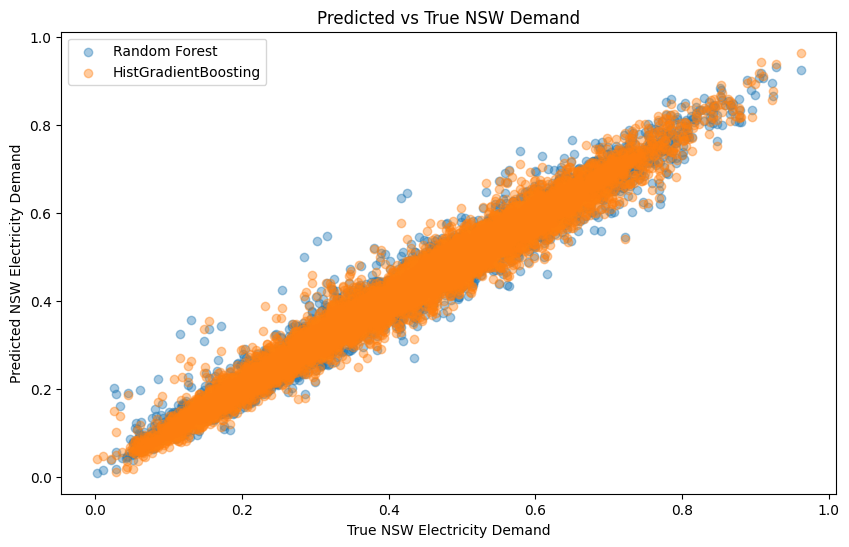

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_hgb = hgb.predict(X_test)

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.4, label="Random Forest")
plt.scatter(y_test, y_pred_hgb, alpha=0.4, label="HistGradientBoosting")
plt.xlabel("True NSW Electricity Demand")
plt.ylabel("Predicted NSW Electricity Demand")
plt.title("Predicted vs True NSW Demand")
plt.legend()
plt.show()


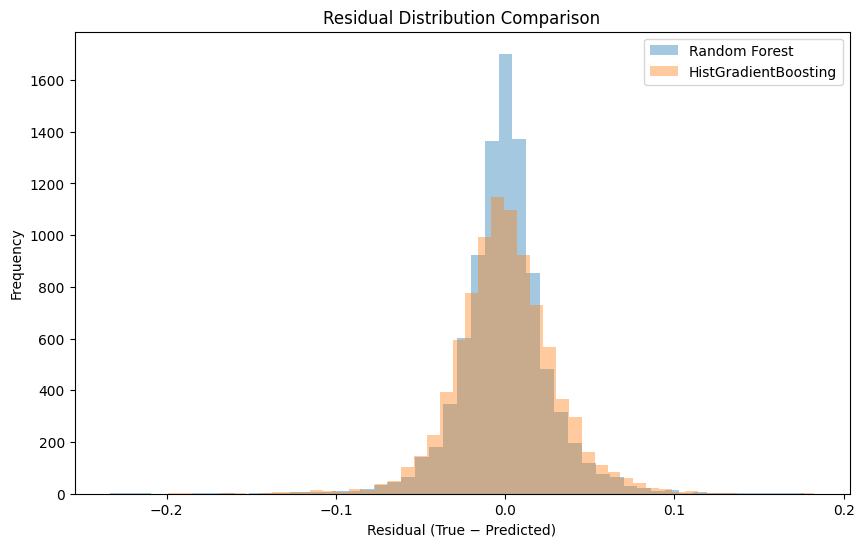

In [12]:
rf_residuals = y_test - y_pred_rf
hgb_residuals = y_test - y_pred_hgb

plt.figure(figsize=(10,6))
plt.hist(rf_residuals, bins=50, alpha=0.4, label="Random Forest")
plt.hist(hgb_residuals, bins=50, alpha=0.4, label="HistGradientBoosting")
plt.xlabel("Residual (True − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution Comparison")
plt.legend()
plt.show()


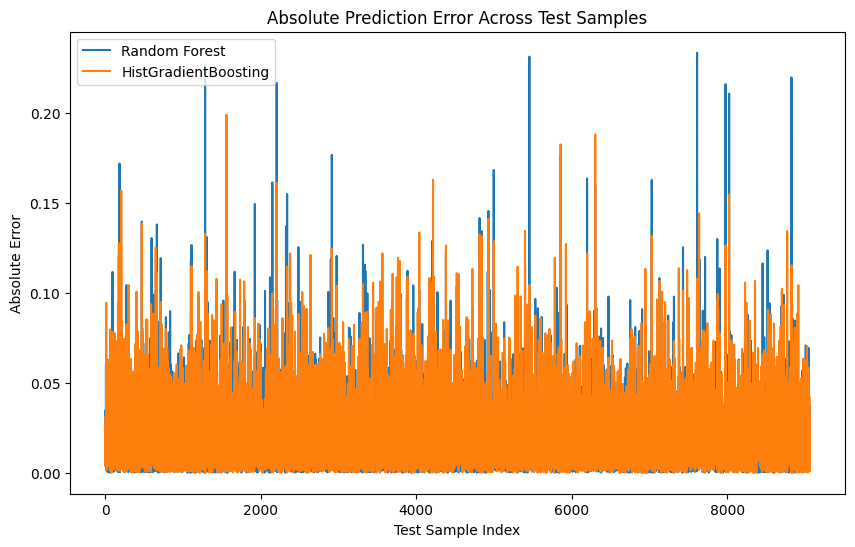

In [13]:
plt.figure(figsize=(10,6))
plt.plot(np.abs(rf_residuals.values), label="Random Forest")
plt.plot(np.abs(hgb_residuals.values), label="HistGradientBoosting")
plt.xlabel("Test Sample Index")
plt.ylabel("Absolute Error")
plt.title("Absolute Prediction Error Across Test Samples")
plt.legend()
plt.show()
